In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# ARIMA modeling

So far, you've learned some of the basics of modeling time with seasonality indicators or oscillating curves. There is one more key branch of time series modeling that you need to know about, and that branch has to do with random movement rather than seasonality. Here, you'll learn about time series that are observed at regular intervals. What that interval actually is doesn't matter nearly as much as its consistency.

Now, the simplest way to approach the evolution of a process is with a single trend term. This typically implies some kind of linear relationship between time and your outcome. As time moves forward, the outcome changes at a given rate per unit of time.

However, you won't always want to model this kind of temporal evolution like this, because your movement is random rather than deterministic. Sometimes, you'll want to say that a certain set of previous values influences your next outcome. In other words, you look back a certain distance to see how you want to look forward. This allows you to adjust to shocks or changes to your system. It also lets outliers fade from influence over time, while incorporating the underlying effects within the randomness.

How do you do this? The most fundamental technique is another extension of least squares regression: *ARIMA modeling* (and its  variations *ARMA* and *ARIMAX*). ARIMA, which stands for *autoregressive integrated moving average*, allows you to add two additional kinds of terms—autoregressions and moving averages—to your specifications. Both autoregressive and moving-average models generally apply to *stationary processes*. Stationarity is a key attribute that's important to understand for ARIMA modeling, so you'll learn more about this attribute next.

## Stationarity and differencing

Now, as mentioned above, you need the data for ARIMA to be stationary. There is, thankfully, an easy way to do this. It's called *differencing*. All this means is subtracting each term from the term that follows it. If there is a constant linear trend, then that difference has a constant expectation.

This is also extendable. If the rate of change is increasing at a constant rate, then taking the difference in differences yields a stationary time series.

So what are you left with after differencing? The goal is to be left with a random stationary process. Now, just because your process is stationary doesn't mean that the expected value of the difference is zero. If it were, the process probably would have been stationary in the first place. Instead, you may have a constant expected value. That would be the *drift* of the original process, which is how much that process is moving on average per time period.

That kind of process, however, is suitable for autoregressive modeling.

## Autoregressive models

An *autoregressive model* is a linear model where the terms of interest are the previous values of the outcome. Simply put, you could say that the outcome today is based on yesterday's outcome and some random noise term.

$$ X_{t} = \alpha + \beta X_{t-1} + \epsilon $$

In this equation, the $\epsilon$ is the noise term, and $\alpha$ is some constant or adjustment factor. And $\beta$ is the amount that the previous value influences your next value.

Simulate an autoregressive model below:

In [14]:
x_ar = [15]
for i in range(500):
    y = 5 + 0.7*x_ar[i-1]
    x_ar.append(float(y))


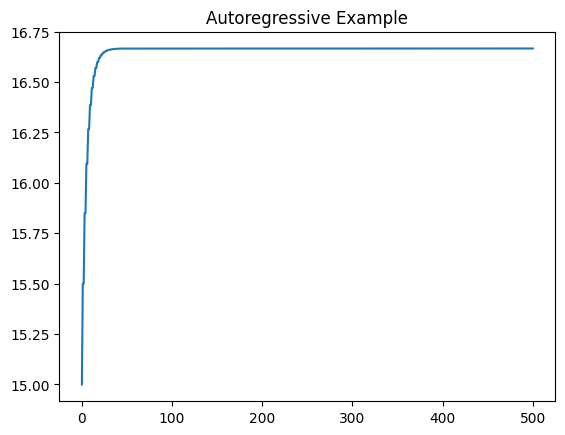

In [15]:
plt.plot(x_ar)
plt.title('Autoregressive Example')
plt.show()

Here you have your random movement generated from an autoregressive model. Specifically, this model is referred to as AR(1), because you are regressing on only one of the previous terms—the first one. Autoregressive models are generalized to AR(n), where $n$ is the number of autoregressive terms included, also called the *order*. In autoregressive models, you generally don't skip terms, so AR(n) also implies that the terms are the lags of `1` through $n$. You also have a $\beta$ of `0.7` and a constant $\alpha$ of `5`. The movement therefore comes from the random error, which in this case is implemented with a standard normal distribution.

Look at the code and try changing the $\beta$ value.

What happens if it's `1`?

What about less than `1`?

And what does it look like if the $\beta$ is `1` and the $\alpha$ is `0`?

## Moving average

The other key component of ARMA modeling is the moving average. Here, shift your focus from the previous *term* to the previous *error*. Start with an example:

In [26]:
x_ma = [15]
e_t = 0
for i in range(500):
    e = np.random.randn(1)
    y = 1 + 0.7*e_t + e
    x_ma.append(float(y))
    e_t=e

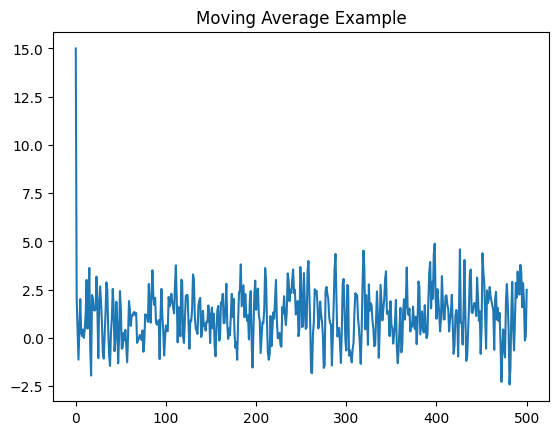

In [27]:
plt.plot(x_ma)
plt.title('Moving Average Example')
plt.show()

Here you have a moving average centered around `1.5` or `2.0`. A moving average model sees the following specification:

$$ X_{t} = \alpha + \beta \epsilon_{t-1} + \epsilon_{t} $$

Again, this is a MA(1) model, where you can make your next term dependent on as many previous errors as necessary, defined as an MA(n) model.

Play around with the values again. How does changing $\beta$ affect the process? What about $\alpha$?

## ARMA modeling

Now, you can combine these two classes of coefficients into a single model to create an *autoregressive moving-average model*, or an *ARMA model*. The ARMA model will be defined in two terms, $p$ and $q$. Here, $p$ is the order of the autoregressive (AR) component, and $q$ is the order of the moving average (MA) component. This will be written as ARMA(p,q). An ARMA(1,1), for example, has the following specification:

$$ X_{t} = \alpha + \beta_{1} X_{t-1} + \beta_{2} \epsilon_{t-1} + \epsilon_{t} $$

## Finding the order

So now that you have these classes of models, you need to figure out how to find the order of a model from data. For ARMA and ARIMA modeling, you'll use statsmodels to both implement and analyze the datasets. If you want to use scikit-learn, you have to rederive columns for AR and MA terms yourself.

What you'll use is a partial autocorrelation function (PACF), which takes the correlation of your time series with a lagged version of itself. Each bar represents the correlation with another lag. So the PACF at `1` is the correlation of your initial series with itself, lagged by `1`. Hence, for these kinds of plots, `0` will always return `1`, because the time series perfectly correlates with itself.

Text(0.5, 1.0, 'AR(1) PACF')

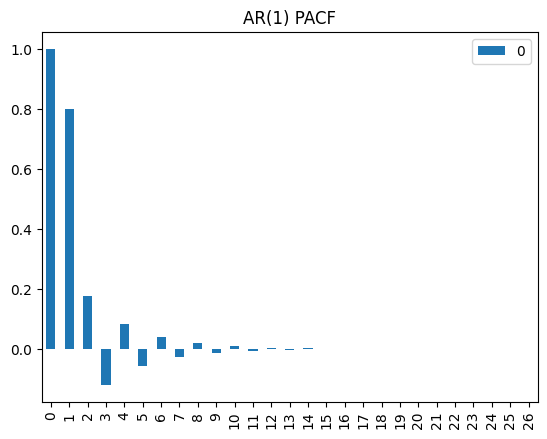

In [28]:
from statsmodels.tsa.stattools import acf, pacf
x_acf = pd.DataFrame(pacf(x_ar))
x_acf.plot(kind='bar')
plt.title("AR(1) PACF")

Text(0.5, 1.0, 'MA(1) PACF')

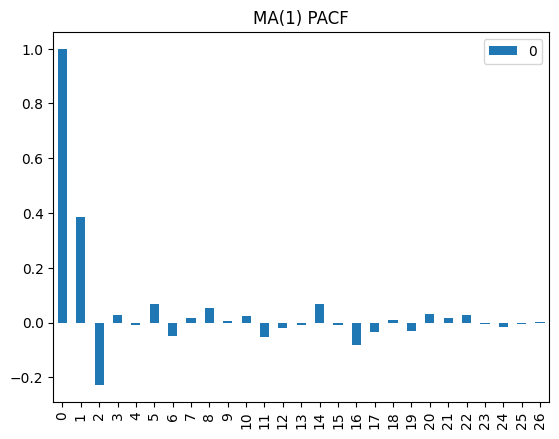

In [29]:
x_acf = pd.DataFrame(pacf(x_ma))
x_acf.plot(kind='bar')
plt.title('MA(1) PACF')

What do these plots mean? Rather than looking for a specific value, what you want to see is where values are outliers. This would indicate a possibly strong autocorrelation. For example, in the AR plot, it's clear that `2` is a strong autocorrelation. And in the MA plot, `1` seems to be strong. This indicates that you should look into $p$ values of `2` and `1`, respectively, for your models.

## The *I* in ARIMA

What if all the values are high? Well, that likely means that you need to use differences, which would come from either manually creating differences or using the ARIMA models and implementing the *I* aspect: integration. You can think of this as the level of differencing (`1` being a simple difference, `2` the difference of differences, and so forth). You can keep taking differences until you get to a stationary process, though it's probably a good idea to make sure that there is a logical reason for that degree of differencing. Chances are, there's nothing in the process that makes an $I$ of `27` logical, even if it looks like it may work.

There are other techniques for finding these parameters as well. The most powerful technique is still grid search and trial and error, which involves attempting several reasonable combinations of $p$ and $q$ and seeing which seems to best match your data. You could also use [information criteria](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/). In the next lesson, you'll work through a guided example of time series modeling; you'll take all of this theory and implement it to build a model for the price of an exchange-traded stock.